
# Deep Factorization Machine for CTR Prediction on Criteo Dataset

A comprehensive implementation of a Deep Factorization Machine (Deep FM) model for click-through rate prediction using PyTorch. This notebook demonstrates advanced deep learning techniques for recommendation systems.

**Features:**
- Custom Deep FM implementation from scratch
- Criteo dataset from Hugging Face
- Comprehensive evaluation with ROC/PR curves and AUC metrics
- Training visualization and analysis
- Binary classification for CTR prediction

**🤖 Generated by [Claude Code](https://claude.ai/code)**

## 1. Environment Setup and Imports

In [1]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision datasets scikit-learn matplotlib seaborn pandas numpy tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, precision_recall_curve, 
    average_precision_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Device configuration
def get_device():    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("Using NVIDIA CUDA GPU")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("Using Apple Silicon MPS GPU")
    else:
        device = torch.device('cpu')
        print("Using CPU")
    return device

device = get_device()
print(f"Device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using NVIDIA CUDA GPU
Device: cuda


## 2. Dataset Loading and Preprocessing

In [3]:
def load_criteo_dataset():
    """Load and prepare Criteo dataset"""
    print("Loading Criteo dataset...")
    
    try:
        # Try to load from local cache first
        if os.path.exists('criteo_data.csv'):
            print("Loading cached Criteo data...")
            df = pd.read_csv('criteo_data.csv')
        else:
            # The following code does not work because the dataset does not exist
            #
            # # Download Criteo dataset using datasets library
            # from datasets import load_dataset
            # print("Downloading Criteo dataset from Hugging Face...")

            # # Load the criteo-small dataset
            # dataset = load_dataset('criteo_small')
            #
            # # Convert to pandas DataFrame
            # train_data = dataset['train'].to_pandas()

            print("Loading Criteo dataset from ./criteo_train_1m.txt ...")
            train_data = pd.read_csv('criteo_train_1m.txt', sep='\t', header=None)
            # Set the columns of the dataframe
            train_data.columns = ['label'] + [f'num_{i}' for i in range(13)] + [f'cat_{i}' for i in range(26)]

            # Use a subset for faster training (first 100k samples)
            # df = train_data.head(100000).copy()
            df = train_data
            
            # Cache the data
            df.to_csv('criteo_data.csv', index=False)
            print(f"Cached dataset to criteo_data.csv")
        
        print(f"Dataset loaded successfully!")
        print(f"Total samples: {len(df)}")
        print(f"Positive samples (clicks): {df['label'].sum()}")
        print(f"Negative samples (no clicks): {len(df) - df['label'].sum()}")
        print(f"Click-through rate: {df['label'].mean():.4f}")
        
        return df
        
    except ImportError as e:
        print("datasets library not available. Creating synthetic Criteo-like data...")
        # do not use fallback dataset, commenting out: return create_synthetic_criteo_data()
        raise(e)

    except Exception as e:
        print(f"Error loading Criteo dataset: {e}")
        # print("Creating synthetic Criteo-like data...")
        # do not use fallback dataset, commenting out: return create_synthetic_criteo_data()
        raise(e)

# will not use fallback data, commenting out
#
# def create_synthetic_criteo_data(n_samples=50000):
#     """Create synthetic Criteo-like data for demonstration"""
#     print(f"Creating synthetic Criteo-like dataset with {n_samples} samples...")
#
#     np.random.seed(42)
#
#     # Create numerical features (13 features like Criteo)
#     numerical_features = {}
#     for i in range(13):
#         # Generate features with different distributions
#         if i < 5:
#             # Log-normal distribution for count-like features
#             numerical_features[f'num_{i}'] = np.random.lognormal(2, 1, n_samples)
#         else:
#             # Normal distribution for other numerical features
#             numerical_features[f'num_{i}'] = np.random.normal(0, 1, n_samples)
#
#     # Create categorical features (26 features like Criteo)
#     categorical_features = {}
#     for i in range(26):
#         # Different cardinalities for different categorical features
#         if i < 10:
#             cardinality = np.random.randint(10, 100)
#         elif i < 20:
#             cardinality = np.random.randint(100, 1000)
#         else:
#             cardinality = np.random.randint(1000, 10000)
#
#         categorical_features[f'cat_{i}'] = np.random.randint(0, cardinality, n_samples)
#
#     # Create synthetic target with realistic CTR (~3%)
#     # Combine some features to create realistic dependencies
#     signal = (
#         0.1 * numerical_features['num_0'] +
#         0.05 * numerical_features['num_1'] -
#         0.02 * numerical_features['num_2'] +
#         0.001 * categorical_features['cat_0'] +
#         0.0001 * categorical_features['cat_1']
#     )
#
#     # Add noise and convert to probabilities
#     noise = np.random.normal(0, 1, n_samples)
#     probabilities = torch.sigmoid(torch.tensor(signal + noise - 3.0)).numpy()  # Shift to get ~3% CTR
#
#     # Generate labels based on probabilities
#     labels = np.random.binomial(1, probabilities)
#
#     # Combine all features
#     data_dict = {'label': labels}
#     data_dict.update(numerical_features)
#     data_dict.update(categorical_features)
#
#     df = pd.DataFrame(data_dict)
#
#     print(f"Synthetic dataset created!")
#     print(f"Total samples: {len(df)}")
#     print(f"Positive samples (clicks): {df['label'].sum()}")
#     print(f"Negative samples (no clicks): {len(df) - df['label'].sum()}")
#     print(f"Click-through rate: {df['label'].mean():.4f}")
#
#     # Cache the synthetic data
#     df.to_csv('criteo_data.csv', index=False)
#
#     return df

# Load the dataset
df = load_criteo_dataset()

Loading Criteo dataset...
Loading Criteo dataset from ./criteo_train_1m.txt ...
Cached dataset to criteo_data.csv
Dataset loaded successfully!
Total samples: 1000000
Positive samples (clicks): 254949
Negative samples (no clicks): 745051
Click-through rate: 0.2549


In [4]:
# Display dataset information
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum().sum())

# Display label distribution
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nLabel distribution (percentages):")
print(df['label'].value_counts(normalize=True) * 100)

Dataset Information:
Shape: (1000000, 40)

Columns: ['label', 'num_0', 'num_1', 'num_2', 'num_3', 'num_4', 'num_5', 'num_6', 'num_7', 'num_8', 'num_9', 'num_10', 'num_11', 'num_12', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11', 'cat_12', 'cat_13', 'cat_14', 'cat_15', 'cat_16', 'cat_17', 'cat_18', 'cat_19', 'cat_20', 'cat_21', 'cat_22', 'cat_23', 'cat_24', 'cat_25']

First few rows:
   label  num_0  num_1  num_2  num_3   num_4  num_5  num_6  num_7  num_8  ...  \
0      0    1.0      1    5.0    0.0  1382.0    4.0   15.0    2.0  181.0  ...   
1      0    2.0      0   44.0    1.0   102.0    8.0    2.0    2.0    4.0  ...   
2      0    2.0      0    1.0   14.0   767.0   89.0    4.0    2.0  245.0  ...   
3      0    NaN    893    NaN    NaN  4392.0    NaN    0.0    0.0    0.0  ...   
4      0    3.0     -1    NaN    0.0     2.0    0.0    3.0    0.0    0.0  ...   

     cat_16    cat_17    cat_18    cat_19    cat_20    cat_21   

## 3. Data Preprocessing and Feature Engineering

In [5]:
class CriteoDataProcessor:
    """Data processor for Criteo dataset"""
    
    def __init__(self):
        self.numerical_columns = []
        self.categorical_columns = []
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.field_dims = []
        
    def fit_transform(self, df):
        """Fit preprocessors and transform data"""
        df = df.copy()
        
        # Separate numerical and categorical columns
        self.numerical_columns = [col for col in df.columns if col.startswith('num_') or col in ['label']]
        self.categorical_columns = [col for col in df.columns if col.startswith('cat_')]
        
        # Remove label from numerical columns
        if 'label' in self.numerical_columns:
            self.numerical_columns.remove('label')
        
        print(f"Numerical columns: {len(self.numerical_columns)}")
        print(f"Categorical columns: {len(self.categorical_columns)}")
        
        # Handle missing values
        for col in self.numerical_columns:
            df[col] = df[col].fillna(0)
            
        for col in self.categorical_columns:
            df[col] = df[col].fillna('missing')
        
        # Scale numerical features
        if self.numerical_columns:
            df[self.numerical_columns] = self.scaler.fit_transform(df[self.numerical_columns])
        
        # Encode categorical features
        offset = 0
        for col in self.categorical_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            # Add offset to make field indices unique across all categorical fields
            df[col] = df[col] + offset
            
            self.label_encoders[col] = le
            field_dim = len(le.classes_)
            self.field_dims.append(field_dim)
            offset += field_dim
        
        print(f"Total categorical field dimension: {sum(self.field_dims)}")
        print(f"Field dimensions: {self.field_dims[:5]}...")  # Show first 5
        
        return df
    
    def transform(self, df):
        """Transform new data using fitted preprocessors"""
        df = df.copy()
        
        # Handle missing values
        for col in self.numerical_columns:
            df[col] = df[col].fillna(0)
            
        for col in self.categorical_columns:
            df[col] = df[col].fillna('missing')
        
        # Scale numerical features
        if self.numerical_columns:
            df[self.numerical_columns] = self.scaler.transform(df[self.numerical_columns])
        
        # Encode categorical features
        offset = 0
        for col in self.categorical_columns:
            le = self.label_encoders[col]
            # Handle unseen categories
            df[col] = df[col].astype(str)
            mask = df[col].isin(le.classes_)
            df.loc[mask, col] = le.transform(df.loc[mask, col])
            df.loc[~mask, col] = 0  # Assign unseen categories to 0
            df[col] = df[col].astype(int) + offset
            offset += len(le.classes_)
        
        return df

# Initialize processor and process data
processor = CriteoDataProcessor()
df_processed = processor.fit_transform(df)

print(f"\nProcessed data shape: {df_processed.shape}")
print(f"Processed data preview:")
print(df_processed.head())

Numerical columns: 13
Categorical columns: 26
Total categorical field dimension: 1296709
Field dimensions: [1261, 531, 321439, 120965, 267]...

Processed data shape: (1000000, 40)
Processed data preview:
   label     num_0     num_1     num_2     num_3     num_4     num_5  \
0      0 -0.124437 -0.265702 -0.036996 -0.652785 -0.250740 -0.214368   
1      0  0.018833 -0.268561  0.092569 -0.527775 -0.269869 -0.204497   
2      0  0.018833 -0.268561 -0.050284  1.097359 -0.259931 -0.004617   
3      0 -0.267707  2.283710 -0.053606 -0.652785 -0.205756 -0.224239   
4      0  0.162103 -0.271419 -0.053606 -0.652785 -0.271363 -0.224239   

      num_6     num_7     num_8  ...  cat_16  cat_17  cat_18  cat_19   cat_20  \
0  0.017562 -0.351611  0.373258  ...  977880  981572  981988  983619   990959   
1 -0.209917 -0.351611 -0.454074  ...  977871  980538  981988  983617  1074702   
2 -0.174920 -0.351611  0.672407  ...  977877  978670  983616  983620  1199405   
3 -0.244914 -0.413460 -0.472771  ...  9

In [6]:
# Split the data
X = df_processed.drop('label', axis=1)
y = df_processed['label']

# Split into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Dataset split:")
print(f"Training: {X_train.shape[0]} samples ({y_train.mean():.4f} CTR)")
print(f"Validation: {X_val.shape[0]} samples ({y_val.mean():.4f} CTR)")
print(f"Test: {X_test.shape[0]} samples ({y_test.mean():.4f} CTR)")

# Separate numerical and categorical features for the model
X_train_num = X_train[processor.numerical_columns].values if processor.numerical_columns else np.array([]).reshape(len(X_train), 0)
X_train_cat = X_train[processor.categorical_columns].values if processor.categorical_columns else np.array([]).reshape(len(X_train), 0)

X_val_num = X_val[processor.numerical_columns].values if processor.numerical_columns else np.array([]).reshape(len(X_val), 0)
X_val_cat = X_val[processor.categorical_columns].values if processor.categorical_columns else np.array([]).reshape(len(X_val), 0)

X_test_num = X_test[processor.numerical_columns].values if processor.numerical_columns else np.array([]).reshape(len(X_test), 0)
X_test_cat = X_test[processor.categorical_columns].values if processor.categorical_columns else np.array([]).reshape(len(X_test), 0)

print(f"\nFeature shapes:")
print(f"Numerical features: {X_train_num.shape}")
print(f"Categorical features: {X_train_cat.shape}")

Dataset split:
Training: 640000 samples (0.2549 CTR)
Validation: 160000 samples (0.2550 CTR)
Test: 200000 samples (0.2550 CTR)

Feature shapes:
Numerical features: (640000, 13)
Categorical features: (640000, 26)


## 4. Deep Factorization Machine Model Implementation

In [98]:
class FMLayer(nn.Module):
    """Factorization Machine layer for second-order feature interactions"""
    
    def __init__(self, numerical_dim, categorical_dims, embedding_dim, dropout=0.2):
        super(FMLayer, self).__init__()
        self.numerical_dim = numerical_dim
        self.categorical_dims = categorical_dims
        self.embedding_dim = embedding_dim
        self.num_categorical_fields = len(categorical_dims)
        
        # Embedding for numerical features - treat each numerical feature as a field
        if numerical_dim > 0:
            self.numerical_embeddings = nn.Linear(numerical_dim, numerical_dim * embedding_dim)
            # Add dropout to numerical embeddings
            self.numerical_dropout = nn.Dropout(dropout)
        
        # Embedding for categorical features with regularization
        if self.num_categorical_fields > 0:
            total_categorical_dim = sum(categorical_dims)
            self.categorical_embeddings = nn.Embedding(total_categorical_dim, embedding_dim)
            # Add dropout to categorical embeddings
            self.categorical_dropout = nn.Dropout(dropout)
        
        # Initialize embeddings
        self._init_weights()
    
    def _init_weights(self):
        """Initialize embedding weights with smaller variance"""
        if hasattr(self, 'numerical_embeddings'):
            # Use smaller initialization for numerical embeddings
            nn.init.normal_(self.numerical_embeddings.weight, mean=0, std=0.01)
            if self.numerical_embeddings.bias is not None:
                nn.init.zeros_(self.numerical_embeddings.bias)
        if hasattr(self, 'categorical_embeddings'):
            # Use smaller initialization for categorical embeddings
            nn.init.normal_(self.categorical_embeddings.weight, mean=0, std=0.01)
    
    def forward(self, x_numerical, x_categorical):
        """Forward pass for FM layer
        Args:
            x_numerical: Numerical features (batch_size, numerical_dim)
            x_categorical: Categorical features (batch_size, num_categorical_fields)
        Returns:
            FM second-order interactions: (batch_size, 1)
        """
        batch_size = x_numerical.shape[0] if x_numerical.shape[1] > 0 else x_categorical.shape[0]
        all_embeddings = []
        
        # Get embeddings for numerical features
        if self.numerical_dim > 0:
            # Transform each numerical feature to embedding space
            num_emb = self.numerical_embeddings(x_numerical)  # (batch_size, numerical_dim * embedding_dim)
            num_emb = num_emb.view(batch_size, self.numerical_dim, self.embedding_dim)  # (batch_size, numerical_dim, embedding_dim)
            
            # Apply dropout to numerical embeddings
            num_emb = self.numerical_dropout(num_emb)
            
            # Multiply by feature values to get weighted embeddings
            x_numerical_expanded = x_numerical.unsqueeze(2)  # (batch_size, numerical_dim, 1)
            num_emb = num_emb * x_numerical_expanded  # Element-wise multiplication
            all_embeddings.append(num_emb)
        
        # Get embeddings for categorical features
        if self.num_categorical_fields > 0:
            cat_emb = self.categorical_embeddings(x_categorical)  # (batch_size, num_categorical_fields, embedding_dim)
            # Apply dropout to categorical embeddings
            cat_emb = self.categorical_dropout(cat_emb)
            all_embeddings.append(cat_emb)
        
        # Concatenate all embeddings
        if all_embeddings:
            embeddings = torch.cat(all_embeddings, dim=1)  # (batch_size, total_fields, embedding_dim)
        else:
            # Should not happen, but handle gracefully
            return torch.zeros(batch_size, 1, device=x_numerical.device if x_numerical.shape[1] > 0 else x_categorical.device)
        
        # Calculate FM second-order interactions
        # Sum of squares: (sum of embeddings)^2
        square_of_sum = torch.sum(embeddings, dim=1) ** 2  # (batch_size, embedding_dim)
        
        # Sum of squares: sum of (embeddings^2)
        sum_of_square = torch.sum(embeddings ** 2, dim=1)  # (batch_size, embedding_dim)
        
        # FM interaction: 0.5 * (square_of_sum - sum_of_square)
        fm_output = 0.5 * (square_of_sum - sum_of_square)  # (batch_size, embedding_dim)
        
        # Sum across embedding dimensions
        fm_output = torch.sum(fm_output, dim=1, keepdim=True)  # (batch_size, 1)
        
        return fm_output


class DeepFMModel(nn.Module):
    """Deep Factorization Machine model implementation with regularization"""
    
    def __init__(self, numerical_dim, categorical_dims, embedding_dim=8, hidden_dims=[256, 128], 
                 dropout=0.5, l2_reg=1e-4, use_bn=True, use_deep=True, use_fm=True):
        super(DeepFMModel, self).__init__()
        
        self.numerical_dim = numerical_dim
        self.categorical_dims = categorical_dims
        self.embedding_dim = embedding_dim
        self.num_categorical_fields = len(categorical_dims)
        self.l2_reg = l2_reg
        self.use_deep = use_deep
        self.use_fm = use_fm
        
        # Linear part (first-order)
        # For numerical features
        if numerical_dim > 0:
            self.linear_numerical = nn.Linear(numerical_dim, 1)
            # Add regularization
            nn.init.normal_(self.linear_numerical.weight, mean=0, std=0.01)
        
        # For categorical features - individual linear weights
        if self.num_categorical_fields > 0:
            total_categorical_dim = sum(categorical_dims)
            self.linear_categorical = nn.Embedding(total_categorical_dim, 1)
            # Smaller initialization for categorical linear weights
            nn.init.normal_(self.linear_categorical.weight, mean=0, std=0.01)
        
        # Factorization Machine part (second-order) - handles both numerical and categorical
        if self.use_fm:
            self.fm_layer = FMLayer(numerical_dim, categorical_dims, embedding_dim, dropout=dropout/2)
        
        # Deep Neural Network part with more regularization
        if self.use_deep:
            deep_input_dim = 0
            if numerical_dim > 0:
                deep_input_dim += numerical_dim
            if self.num_categorical_fields > 0:
                deep_input_dim += self.num_categorical_fields * embedding_dim
            
            # More conservative deep layers
            self.deep_layers = nn.ModuleList()
            prev_dim = deep_input_dim
            
            for i, hidden_dim in enumerate(hidden_dims):
                self.deep_layers.append(nn.Linear(prev_dim, hidden_dim))
                # Smaller initialization for deep layers
                nn.init.normal_(self.deep_layers[-1].weight, mean=0, std=0.01)
                
                if use_bn:
                    self.deep_layers.append(nn.BatchNorm1d(hidden_dim))
                self.deep_layers.append(nn.ReLU())
                # Increase dropout for later layers
                layer_dropout = dropout * (1 + i * 0.1)  # Progressive dropout
                self.deep_layers.append(nn.Dropout(min(layer_dropout, 0.7)))
                prev_dim = hidden_dim
            
            # Output layer for deep part
            self.deep_output = nn.Linear(prev_dim, 1)
            nn.init.normal_(self.deep_output.weight, mean=0, std=0.01)
        
        # Global bias
        self.bias = nn.Parameter(torch.zeros(1))
        
        # Weight for combining different components
        self.component_weights = nn.Parameter(torch.ones(3))  # linear, fm, deep
    
    def l2_penalty(self):
        """Calculate L2 regularization penalty"""
        l2_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:  # Don't regularize embeddings too heavily
                l2_loss += torch.norm(param, p=2)
        return self.l2_reg * l2_loss
    
    def forward(self, x_numerical, x_categorical):
        """Forward pass
        Args:
            x_numerical: Numerical features (batch_size, numerical_dim)
            x_categorical: Categorical features (batch_size, num_categorical_fields)
        """
        batch_size = x_numerical.shape[0] if x_numerical.shape[1] > 0 else x_categorical.shape[0]
        
        outputs = []
        
        # 1. Linear part (first-order)
        linear_output = self.bias
        
        if self.numerical_dim > 0:
            linear_output = linear_output + self.linear_numerical(x_numerical).squeeze()
        
        if self.num_categorical_fields > 0:
            cat_linear = self.linear_categorical(x_categorical).squeeze()  # (batch_size, num_fields)
            linear_output = linear_output + torch.sum(cat_linear, dim=1)
        
        outputs.append(linear_output * self.component_weights[0])
        
        # 2. FM part (second-order interactions)
        if self.use_fm:
            fm_output = self.fm_layer(x_numerical, x_categorical).squeeze()  # (batch_size,)
            outputs.append(fm_output * self.component_weights[1])
        
        # 3. Deep part
        if self.use_deep:
            deep_input_parts = []
            
            # Add numerical features
            if self.numerical_dim > 0:
                deep_input_parts.append(x_numerical)
            
            # Add categorical embeddings (reuse embeddings from FM layer if available)
            if self.num_categorical_fields > 0:
                if self.use_fm:
                    cat_embeddings = self.fm_layer.categorical_embeddings(x_categorical)
                else:
                    # Create separate embeddings for deep part if FM is not used
                    if not hasattr(self, 'deep_categorical_embeddings'):
                        total_categorical_dim = sum(self.categorical_dims)
                        self.deep_categorical_embeddings = nn.Embedding(total_categorical_dim, self.embedding_dim).to(x_categorical.device)
                        nn.init.normal_(self.deep_categorical_embeddings.weight, mean=0, std=0.01)
                    cat_embeddings = self.deep_categorical_embeddings(x_categorical)
                
                cat_embeddings_flat = cat_embeddings.view(batch_size, -1)  # (batch_size, num_fields * embedding_dim)
                deep_input_parts.append(cat_embeddings_flat)
            
            # Concatenate all inputs for deep network
            if deep_input_parts:
                deep_input = torch.cat(deep_input_parts, dim=1)
            else:
                deep_input = torch.zeros(batch_size, 1, device=x_numerical.device if x_numerical.shape[1] > 0 else x_categorical.device)
            
            # Pass through deep layers
            deep_output = deep_input
            for layer in self.deep_layers:
                deep_output = layer(deep_output)
            
            deep_output = self.deep_output(deep_output).squeeze()  # (batch_size,)
            outputs.append(deep_output * self.component_weights[2])
        
        # 4. Combine all parts
        total_output = sum(outputs) if len(outputs) > 1 else outputs[0]
        
        return torch.sigmoid(total_output)


# Initialize model with better regularization
numerical_dim = len(processor.numerical_columns)
categorical_dims = processor.field_dims

print(f"Model configuration:")
print(f"Numerical dimension: {numerical_dim}")
print(f"Categorical field dimensions: {len(categorical_dims)} fields")
print(f"Total categorical dimension: {sum(categorical_dims)}")

model = DeepFMModel(
    numerical_dim=numerical_dim,
    categorical_dims=categorical_dims,
    embedding_dim=16,  # Reduced from 16
    hidden_dims=[256, 128],  # Reduced from [512, 256, 128]
    dropout=0.5,  # Increased from 0.3
    l2_reg=0.001,  # Added L2 regularization
    use_bn=True,
    use_deep=False,
    use_fm=True
)

model = model.to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB")

Model configuration:
Numerical dimension: 13
Categorical field dimensions: 26 fields
Total categorical dimension: 1296709

Model Statistics:
Total parameters: 22,046,983
Trainable parameters: 22,046,983
Model size: 84.10 MB


## 5. Training Setup and Data Loaders

In [99]:
class CriteoDataset(Dataset):
    """Custom Dataset for Criteo data"""
    
    def __init__(self, X_numerical, X_categorical, y):
        self.X_numerical = torch.FloatTensor(X_numerical)
        self.X_categorical = torch.LongTensor(X_categorical) if X_categorical.shape[1] > 0 else torch.LongTensor(X_categorical)
        self.y = torch.FloatTensor(y.values if hasattr(y, 'values') else y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return {
            'numerical': self.X_numerical[idx],
            'categorical': self.X_categorical[idx],
            'target': self.y[idx]
        }


# Create datasets
train_dataset = CriteoDataset(X_train_num, X_train_cat, y_train)
val_dataset = CriteoDataset(X_val_num, X_val_cat, y_val)
test_dataset = CriteoDataset(X_test_num, X_test_cat, y_test)

# Create data loaders
BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Data loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

# Test data loading
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"Numerical: {sample_batch['numerical'].shape}")
print(f"Categorical: {sample_batch['categorical'].shape}")
print(f"Target: {sample_batch['target'].shape}")

Data loaders created:
Training batches: 625
Validation batches: 157
Test batches: 196
Batch size: 1024

Sample batch shapes:
Numerical: torch.Size([1024, 13])
Categorical: torch.Size([1024, 26])
Target: torch.Size([1024])


## 6. Training and Evaluation Functions

In [100]:
class MetricsTracker:
    """Track training and validation metrics"""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.train_losses = []
        self.val_losses = []
        self.train_aucs = []
        self.val_aucs = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.epoch_times = []
        self.learning_rates = []
    
    def update(self, train_loss, val_loss, train_auc, val_auc, train_acc, val_acc, epoch_time, lr):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_aucs.append(train_auc)
        self.val_aucs.append(val_auc)
        self.train_accuracies.append(train_acc)
        self.val_accuracies.append(val_acc)
        self.epoch_times.append(epoch_time)
        self.learning_rates.append(lr)


def evaluate_model(model, data_loader, criterion, device):
    """Evaluate the model on given data"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            x_num = batch['numerical'].to(device)
            x_cat = batch['categorical'].to(device)
            labels = batch['target'].to(device)
            
            outputs = model(x_num, x_cat)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            all_predictions.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    
    # Calculate metrics
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Binary predictions for accuracy
    binary_predictions = (all_predictions > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, binary_predictions)
    
    # AUC
    auc = roc_auc_score(all_labels, all_predictions)
    
    return avg_loss, accuracy, auc, all_predictions, all_labels


def train_epoch(model, data_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    
    for batch in progress_bar:
        x_num = batch['numerical'].to(device)
        x_cat = batch['categorical'].to(device)
        labels = batch['target'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(x_num, x_cat)
        loss = criterion(outputs, labels)
        
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(data_loader)
    
    # Calculate metrics
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Binary predictions for accuracy
    binary_predictions = (all_predictions > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, binary_predictions)
    
    # AUC
    auc = roc_auc_score(all_labels, all_predictions)
    
    return avg_loss, accuracy, auc

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


## 7. Model Training

In [101]:
# Training hyperparameters with better regularization
EPOCHS = 50
LEARNING_RATE = 0.0005  # Reduced learning rate
WEIGHT_DECAY = 1e-4  # Additional weight decay in optimizer

print(f"Training hyperparameters:")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Batch Size: {BATCH_SIZE}")

# Loss and optimizer with additional regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# More aggressive learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2, min_lr=1e-6
)

# Alternative: Step scheduler for more controlled decay
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Metrics tracker
metrics_tracker = MetricsTracker()

# Training loop with enhanced regularization
print(f"\nStarting training with enhanced regularization...")
print("=" * 50)

best_val_auc = 0
early_stopping_patience = 10
early_stopping_counter = 0

import time

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 30)
    
    # Training with L2 regularization
    model.train()
    total_loss = 0
    total_reg_loss = 0
    all_predictions = []
    all_labels = []
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch in progress_bar:
        x_num = batch['numerical'].to(device)
        x_cat = batch['categorical'].to(device)
        labels = batch['target'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(x_num, x_cat)
        
        # Base loss
        base_loss = criterion(outputs, labels)
        
        # Add L2 regularization penalty
        l2_penalty = model.l2_penalty()
        
        # Total loss
        loss = base_loss + l2_penalty
        
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # More aggressive clipping
        optimizer.step()
        
        total_loss += base_loss.item()
        total_reg_loss += l2_penalty.item()
        
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{base_loss.item():.4f}',
            'L2': f'{l2_penalty.item():.4f}'
        })
    
    # Calculate training metrics
    train_loss = total_loss / len(train_loader)
    train_reg_loss = total_reg_loss / len(train_loader)
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    binary_predictions = (all_predictions > 0.5).astype(int)
    train_acc = accuracy_score(all_labels, binary_predictions)
    train_auc = roc_auc_score(all_labels, all_predictions)
    
    # Validation
    val_loss, val_acc, val_auc, _, _ = evaluate_model(
        model, val_loader, criterion, device
    )
    
    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    epoch_time = time.time() - epoch_start_time
    
    # Update metrics
    metrics_tracker.update(
        train_loss, val_loss, train_auc, val_auc, 
        train_acc, val_acc, epoch_time, current_lr
    )
    
    print(f"Train Loss: {train_loss:.4f} (L2: {train_reg_loss:.4f}), Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    
    # Enhanced early stopping with validation AUC monitoring
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_deep_fm_model.pth')
        print("New best model saved!")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"No improvement for {early_stopping_counter} epochs")
    
    # Additional check: stop if validation loss increases too much
    if len(metrics_tracker.val_losses) > 1:
        val_loss_increase = val_loss - min(metrics_tracker.val_losses)
        if val_loss_increase > 0.1:  # If validation loss increases by more than 0.1
            print(f"Validation loss increased significantly ({val_loss_increase:.4f})")
            early_stopping_counter += 1
    
    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs")
        break
    
    # Stop if learning rate becomes too small
    if current_lr < 1e-6:
        print(f"\nLearning rate too small ({current_lr:.2e}), stopping training")
        break

print(f"\nTraining completed!")
print(f"Best validation AUC: {best_val_auc:.4f}")

# Print model component weights to understand what's working
if hasattr(model, 'component_weights'):
    weights = torch.softmax(model.component_weights, dim=0)
    print(f"\nModel component weights (after softmax):")
    print(f"Linear: {weights[0].item():.3f}")
    print(f"FM: {weights[1].item():.3f}")
    print(f"Deep: {weights[2].item():.3f}")

Training hyperparameters:
Epochs: 50
Learning Rate: 0.0005
Weight Decay: 0.0001
Batch Size: 1024

Starting training with enhanced regularization...

Epoch 1/50
------------------------------


Train Loss: 0.5521 (L2: 0.0055), Train Acc: 0.7645, Train AUC: 0.7165
Val Loss: 0.5105, Val Acc: 0.7771, Val AUC: 0.7644
Learning Rate: 5.00e-04
Epoch Time: 10.72s
New best model saved!

Epoch 2/50
------------------------------


Train Loss: 0.5107 (L2: 0.0063), Train Acc: 0.7783, Train AUC: 0.7700
Val Loss: 0.5028, Val Acc: 0.7794, Val AUC: 0.7717
Learning Rate: 5.00e-04
Epoch Time: 10.33s
New best model saved!

Epoch 3/50
------------------------------


Train Loss: 0.5035 (L2: 0.0066), Train Acc: 0.7804, Train AUC: 0.7762
Val Loss: 0.5094, Val Acc: 0.7811, Val AUC: 0.7743
Learning Rate: 5.00e-04
Epoch Time: 9.98s
New best model saved!

Epoch 4/50
------------------------------


Train Loss: 0.5040 (L2: 0.0066), Train Acc: 0.7818, Train AUC: 0.7792
Val Loss: 0.5078, Val Acc: 0.7816, Val AUC: 0.7758
Learning Rate: 5.00e-04
Epoch Time: 10.57s
New best model saved!

Epoch 5/50
------------------------------


Train Loss: 0.5021 (L2: 0.0067), Train Acc: 0.7824, Train AUC: 0.7812
Val Loss: 0.5011, Val Acc: 0.7816, Val AUC: 0.7763
Learning Rate: 5.00e-04
Epoch Time: 10.33s
New best model saved!

Epoch 6/50
------------------------------


Train Loss: 0.4997 (L2: 0.0067), Train Acc: 0.7833, Train AUC: 0.7823
Val Loss: 0.4940, Val Acc: 0.7812, Val AUC: 0.7771
Learning Rate: 5.00e-04
Epoch Time: 10.56s
New best model saved!

Epoch 7/50
------------------------------


Train Loss: 0.4960 (L2: 0.0068), Train Acc: 0.7833, Train AUC: 0.7834
Val Loss: 0.5050, Val Acc: 0.7812, Val AUC: 0.7763
Learning Rate: 5.00e-04
Epoch Time: 10.64s
No improvement for 1 epochs

Epoch 8/50
------------------------------


Train Loss: 0.5024 (L2: 0.0070), Train Acc: 0.7836, Train AUC: 0.7841
Val Loss: 0.5004, Val Acc: 0.7817, Val AUC: 0.7765
Learning Rate: 5.00e-04
Epoch Time: 10.47s
No improvement for 2 epochs

Epoch 9/50
------------------------------


Train Loss: 0.4982 (L2: 0.0071), Train Acc: 0.7841, Train AUC: 0.7856
Val Loss: 0.5129, Val Acc: 0.7823, Val AUC: 0.7778
Learning Rate: 1.50e-04
Epoch Time: 10.49s
New best model saved!

Epoch 10/50
------------------------------


Train Loss: 0.4807 (L2: 0.0067), Train Acc: 0.7891, Train AUC: 0.7952
Val Loss: 0.4849, Val Acc: 0.7831, Val AUC: 0.7805
Learning Rate: 1.50e-04
Epoch Time: 10.55s
New best model saved!

Epoch 11/50
------------------------------


Train Loss: 0.4725 (L2: 0.0064), Train Acc: 0.7898, Train AUC: 0.7970
Val Loss: 0.4863, Val Acc: 0.7835, Val AUC: 0.7811
Learning Rate: 1.50e-04
Epoch Time: 10.31s
New best model saved!

Epoch 12/50
------------------------------


Train Loss: 0.4712 (L2: 0.0064), Train Acc: 0.7907, Train AUC: 0.7979
Val Loss: 0.4843, Val Acc: 0.7839, Val AUC: 0.7818
Learning Rate: 1.50e-04
Epoch Time: 10.00s
New best model saved!

Epoch 13/50
------------------------------


Train Loss: 0.4697 (L2: 0.0063), Train Acc: 0.7910, Train AUC: 0.7989
Val Loss: 0.4787, Val Acc: 0.7839, Val AUC: 0.7819
Learning Rate: 1.50e-04
Epoch Time: 10.51s
New best model saved!

Epoch 14/50
------------------------------


Train Loss: 0.4676 (L2: 0.0063), Train Acc: 0.7915, Train AUC: 0.7997
Val Loss: 0.4857, Val Acc: 0.7840, Val AUC: 0.7828
Learning Rate: 1.50e-04
Epoch Time: 10.24s
New best model saved!

Epoch 15/50
------------------------------


Train Loss: 0.4698 (L2: 0.0063), Train Acc: 0.7918, Train AUC: 0.8004
Val Loss: 0.4795, Val Acc: 0.7844, Val AUC: 0.7823
Learning Rate: 1.50e-04
Epoch Time: 10.48s
No improvement for 1 epochs

Epoch 16/50
------------------------------


Train Loss: 0.4672 (L2: 0.0062), Train Acc: 0.7921, Train AUC: 0.8007
Val Loss: 0.4798, Val Acc: 0.7842, Val AUC: 0.7829
Learning Rate: 4.50e-05
Epoch Time: 10.94s
New best model saved!

Epoch 17/50
------------------------------


Train Loss: 0.4573 (L2: 0.0061), Train Acc: 0.7946, Train AUC: 0.8065
Val Loss: 0.4754, Val Acc: 0.7849, Val AUC: 0.7838
Learning Rate: 4.50e-05
Epoch Time: 10.85s
New best model saved!

Epoch 18/50
------------------------------


Train Loss: 0.4567 (L2: 0.0061), Train Acc: 0.7950, Train AUC: 0.8072
Val Loss: 0.4763, Val Acc: 0.7848, Val AUC: 0.7836
Learning Rate: 4.50e-05
Epoch Time: 10.96s
No improvement for 1 epochs

Epoch 19/50
------------------------------


Train Loss: 0.4583 (L2: 0.0060), Train Acc: 0.7949, Train AUC: 0.8067
Val Loss: 0.4742, Val Acc: 0.7848, Val AUC: 0.7840
Learning Rate: 4.50e-05
Epoch Time: 11.28s
New best model saved!

Epoch 20/50
------------------------------


Train Loss: 0.4585 (L2: 0.0060), Train Acc: 0.7951, Train AUC: 0.8072
Val Loss: 0.4746, Val Acc: 0.7846, Val AUC: 0.7839
Learning Rate: 4.50e-05
Epoch Time: 10.61s
No improvement for 1 epochs

Epoch 21/50
------------------------------


Train Loss: 0.4572 (L2: 0.0060), Train Acc: 0.7954, Train AUC: 0.8075
Val Loss: 0.4756, Val Acc: 0.7846, Val AUC: 0.7840
Learning Rate: 4.50e-05
Epoch Time: 10.85s
New best model saved!

Epoch 22/50
------------------------------


Train Loss: 0.4582 (L2: 0.0059), Train Acc: 0.7950, Train AUC: 0.8075
Val Loss: 0.4747, Val Acc: 0.7848, Val AUC: 0.7842
Learning Rate: 1.35e-05
Epoch Time: 10.65s
New best model saved!

Epoch 23/50
------------------------------


Train Loss: 0.4536 (L2: 0.0059), Train Acc: 0.7964, Train AUC: 0.8100
Val Loss: 0.4739, Val Acc: 0.7848, Val AUC: 0.7844
Learning Rate: 1.35e-05
Epoch Time: 10.71s
New best model saved!

Epoch 24/50
------------------------------


Train Loss: 0.4539 (L2: 0.0059), Train Acc: 0.7966, Train AUC: 0.8097
Val Loss: 0.4751, Val Acc: 0.7851, Val AUC: 0.7845
Learning Rate: 1.35e-05
Epoch Time: 10.82s
New best model saved!

Epoch 25/50
------------------------------


Train Loss: 0.4540 (L2: 0.0059), Train Acc: 0.7969, Train AUC: 0.8099
Val Loss: 0.4751, Val Acc: 0.7851, Val AUC: 0.7845
Learning Rate: 1.35e-05
Epoch Time: 10.73s
New best model saved!

Epoch 26/50
------------------------------


Train Loss: 0.4536 (L2: 0.0059), Train Acc: 0.7964, Train AUC: 0.8102
Val Loss: 0.4746, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 4.05e-06
Epoch Time: 10.82s
No improvement for 1 epochs

Epoch 27/50
------------------------------


Train Loss: 0.4535 (L2: 0.0059), Train Acc: 0.7970, Train AUC: 0.8106
Val Loss: 0.4745, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 4.05e-06
Epoch Time: 10.66s
New best model saved!

Epoch 28/50
------------------------------


Train Loss: 0.4546 (L2: 0.0059), Train Acc: 0.7972, Train AUC: 0.8108
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 4.05e-06
Epoch Time: 10.62s
New best model saved!

Epoch 29/50
------------------------------


Train Loss: 0.4526 (L2: 0.0059), Train Acc: 0.7972, Train AUC: 0.8107
Val Loss: 0.4744, Val Acc: 0.7848, Val AUC: 0.7845
Learning Rate: 1.21e-06
Epoch Time: 10.84s
New best model saved!

Epoch 30/50
------------------------------


Train Loss: 0.4533 (L2: 0.0059), Train Acc: 0.7972, Train AUC: 0.8111
Val Loss: 0.4744, Val Acc: 0.7848, Val AUC: 0.7845
Learning Rate: 1.21e-06
Epoch Time: 10.30s
New best model saved!

Epoch 31/50
------------------------------


Train Loss: 0.4531 (L2: 0.0059), Train Acc: 0.7971, Train AUC: 0.8111
Val Loss: 0.4739, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 1.21e-06
Epoch Time: 10.33s
New best model saved!

Epoch 32/50
------------------------------


Train Loss: 0.4544 (L2: 0.0059), Train Acc: 0.7970, Train AUC: 0.8110
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 1.00e-06
Epoch Time: 10.95s
No improvement for 1 epochs

Epoch 33/50
------------------------------


Train Loss: 0.4536 (L2: 0.0059), Train Acc: 0.7971, Train AUC: 0.8110
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 1.00e-06
Epoch Time: 10.67s
New best model saved!

Epoch 34/50
------------------------------


Train Loss: 0.4539 (L2: 0.0059), Train Acc: 0.7967, Train AUC: 0.8111
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 11.04s
New best model saved!

Epoch 35/50
------------------------------


Train Loss: 0.4533 (L2: 0.0059), Train Acc: 0.7973, Train AUC: 0.8110
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 1.00e-06
Epoch Time: 10.98s
No improvement for 1 epochs

Epoch 36/50
------------------------------


Train Loss: 0.4538 (L2: 0.0059), Train Acc: 0.7968, Train AUC: 0.8112
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 1.00e-06
Epoch Time: 10.01s
No improvement for 2 epochs

Epoch 37/50
------------------------------


Train Loss: 0.4550 (L2: 0.0059), Train Acc: 0.7966, Train AUC: 0.8109
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 1.00e-06
Epoch Time: 10.09s
No improvement for 3 epochs

Epoch 38/50
------------------------------


Train Loss: 0.4529 (L2: 0.0059), Train Acc: 0.7971, Train AUC: 0.8113
Val Loss: 0.4744, Val Acc: 0.7849, Val AUC: 0.7845
Learning Rate: 1.00e-06
Epoch Time: 10.83s
No improvement for 4 epochs

Epoch 39/50
------------------------------


Train Loss: 0.4525 (L2: 0.0059), Train Acc: 0.7968, Train AUC: 0.8110
Val Loss: 0.4738, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.51s
New best model saved!

Epoch 40/50
------------------------------


Train Loss: 0.4527 (L2: 0.0059), Train Acc: 0.7973, Train AUC: 0.8112
Val Loss: 0.4738, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.69s
New best model saved!

Epoch 41/50
------------------------------


Train Loss: 0.4533 (L2: 0.0059), Train Acc: 0.7972, Train AUC: 0.8109
Val Loss: 0.4738, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.53s
No improvement for 1 epochs

Epoch 42/50
------------------------------


Train Loss: 0.4547 (L2: 0.0059), Train Acc: 0.7970, Train AUC: 0.8109
Val Loss: 0.4743, Val Acc: 0.7849, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 9.93s
No improvement for 2 epochs

Epoch 43/50
------------------------------


Train Loss: 0.4542 (L2: 0.0059), Train Acc: 0.7975, Train AUC: 0.8107
Val Loss: 0.4743, Val Acc: 0.7849, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.03s
No improvement for 3 epochs

Epoch 44/50
------------------------------


Train Loss: 0.4533 (L2: 0.0059), Train Acc: 0.7976, Train AUC: 0.8111
Val Loss: 0.4738, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.01s
No improvement for 4 epochs

Epoch 45/50
------------------------------


Train Loss: 0.4536 (L2: 0.0059), Train Acc: 0.7971, Train AUC: 0.8108
Val Loss: 0.4743, Val Acc: 0.7849, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 9.94s
No improvement for 5 epochs

Epoch 46/50
------------------------------


Train Loss: 0.4549 (L2: 0.0059), Train Acc: 0.7971, Train AUC: 0.8110
Val Loss: 0.4743, Val Acc: 0.7849, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.44s
No improvement for 6 epochs

Epoch 47/50
------------------------------


Train Loss: 0.4549 (L2: 0.0059), Train Acc: 0.7970, Train AUC: 0.8111
Val Loss: 0.4744, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.55s
New best model saved!

Epoch 48/50
------------------------------


Train Loss: 0.4543 (L2: 0.0059), Train Acc: 0.7970, Train AUC: 0.8107
Val Loss: 0.4743, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.12s
New best model saved!

Epoch 49/50
------------------------------


Train Loss: 0.4531 (L2: 0.0059), Train Acc: 0.7970, Train AUC: 0.8110
Val Loss: 0.4738, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.64s
New best model saved!

Epoch 50/50
------------------------------


Train Loss: 0.4532 (L2: 0.0059), Train Acc: 0.7969, Train AUC: 0.8108
Val Loss: 0.4738, Val Acc: 0.7850, Val AUC: 0.7846
Learning Rate: 1.00e-06
Epoch Time: 10.59s
No improvement for 1 epochs

Training completed!
Best validation AUC: 0.7846

Model component weights (after softmax):
Linear: 0.549
FM: 0.335
Deep: 0.117


## 8. Model Evaluation on Test Set

In [102]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_deep_fm_model.pth'))

# Test evaluation
print("Evaluating on test set...")
test_loss, test_acc, test_auc, test_predictions, test_labels = evaluate_model(
    model, test_loader, criterion, device
)

# Calculate additional metrics
test_predictions_binary = (test_predictions > 0.5).astype(int)
precision = precision_score(test_labels, test_predictions_binary)
recall = recall_score(test_labels, test_predictions_binary)
f1 = f1_score(test_labels, test_predictions_binary)

# Precision-Recall AUC
pr_auc = average_precision_score(test_labels, test_predictions)

print(f"\n" + "=" * 50)
print(f"FINAL TEST RESULTS")
print(f"=" * 50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Test AUC-PR: {pr_auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
class_names = ['No Click', 'Click']
print(classification_report(test_labels, test_predictions_binary, target_names=class_names))

Evaluating on test set...



FINAL TEST RESULTS
Test Loss: 0.4780
Test Accuracy: 0.7841
Test AUC-ROC: 0.7854
Test AUC-PR: 0.5692
Test Precision: 0.6530
Test Recall: 0.3271
Test F1-Score: 0.4359

Detailed Classification Report:
              precision    recall  f1-score   support

    No Click       0.80      0.94      0.87    149010
       Click       0.65      0.33      0.44     50990

    accuracy                           0.78    200000
   macro avg       0.73      0.63      0.65    200000
weighted avg       0.77      0.78      0.76    200000



## 9. Comprehensive Visualization and Analysis

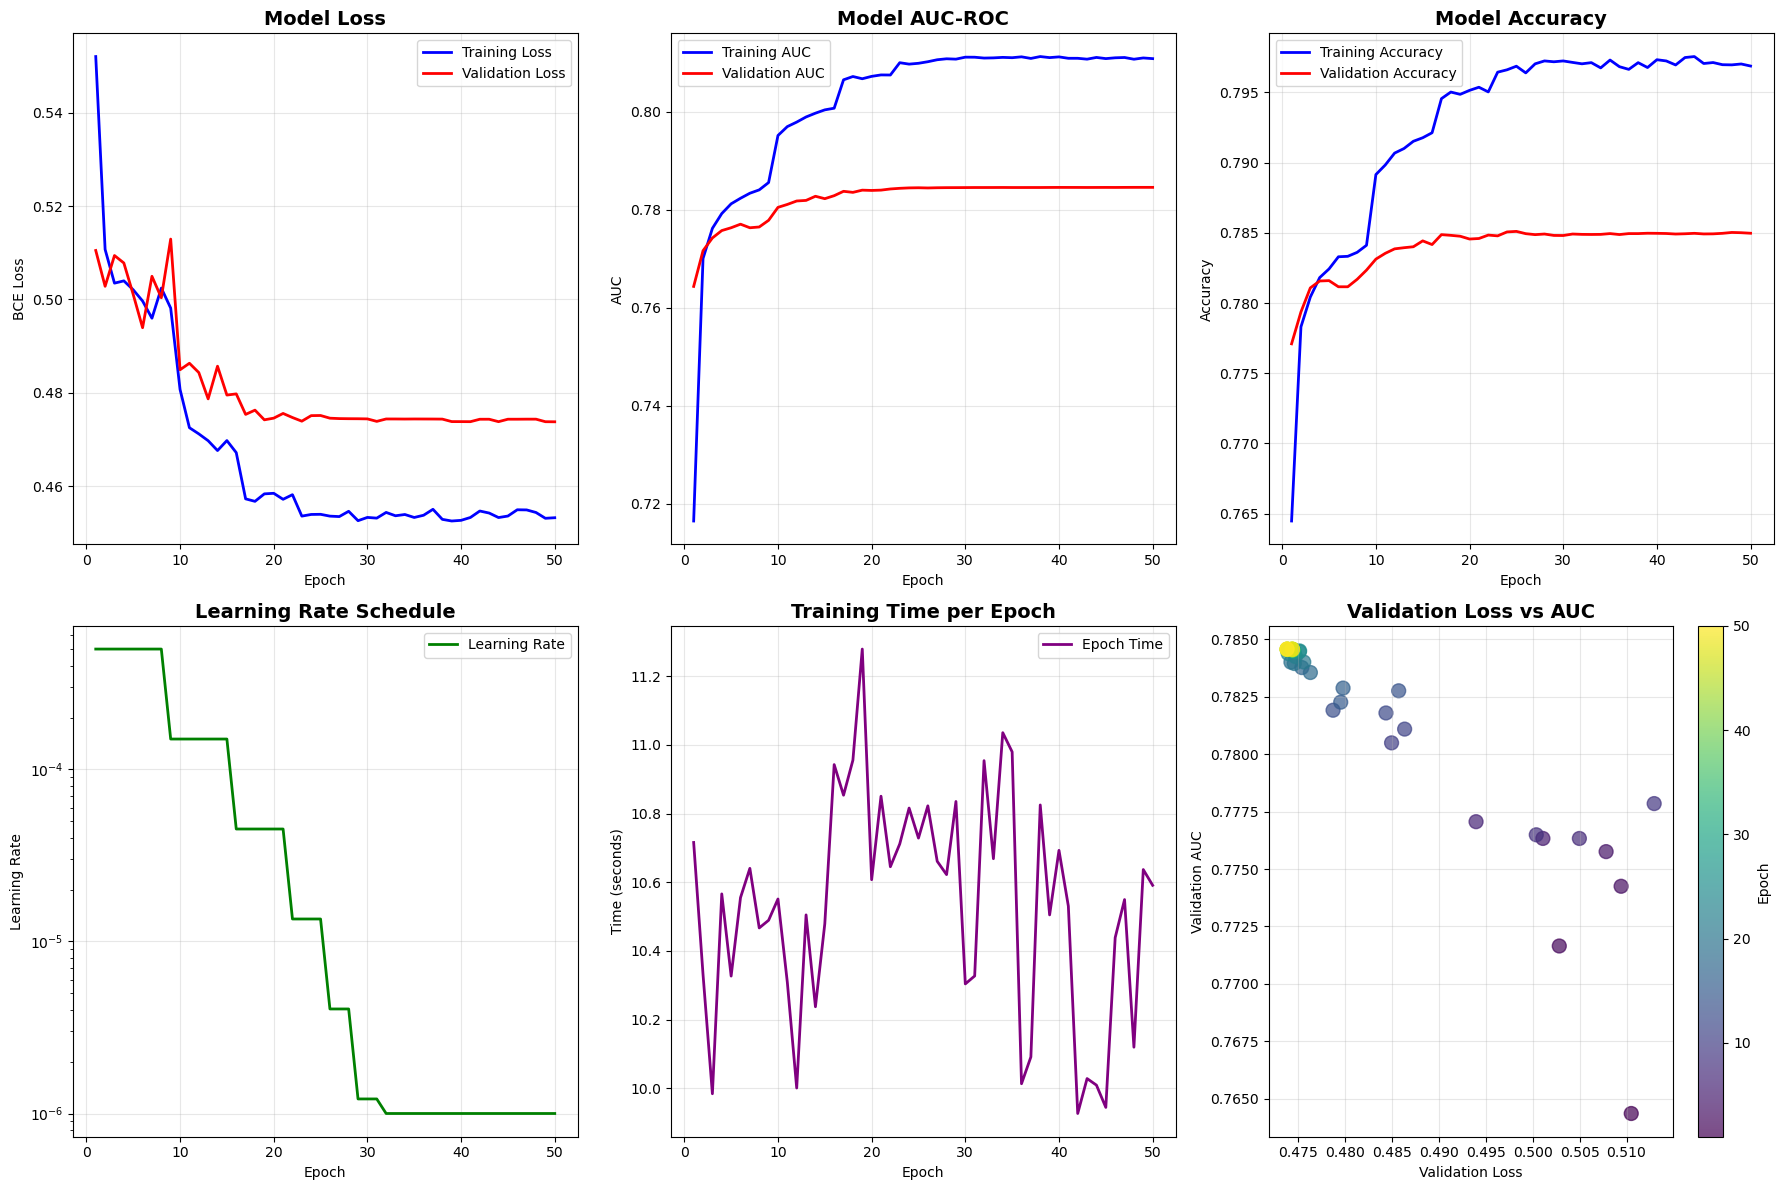

In [103]:
def plot_training_history(metrics_tracker):
    """Plot comprehensive training history"""
    epochs = range(1, len(metrics_tracker.train_losses) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Loss
    axes[0, 0].plot(epochs, metrics_tracker.train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, metrics_tracker.val_losses, 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('BCE Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # AUC
    axes[0, 1].plot(epochs, metrics_tracker.train_aucs, 'b-', label='Training AUC', linewidth=2)
    axes[0, 1].plot(epochs, metrics_tracker.val_aucs, 'r-', label='Validation AUC', linewidth=2)
    axes[0, 1].set_title('Model AUC-ROC', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('AUC')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 2].plot(epochs, metrics_tracker.train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 2].plot(epochs, metrics_tracker.val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 2].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(epochs, metrics_tracker.learning_rates, 'g-', label='Learning Rate', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Training Time
    axes[1, 1].plot(epochs, metrics_tracker.epoch_times, 'purple', label='Epoch Time', linewidth=2)
    axes[1, 1].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Validation Loss vs AUC
    axes[1, 2].scatter(metrics_tracker.val_losses, metrics_tracker.val_aucs, 
                      c=epochs, cmap='viridis', s=100, alpha=0.7)
    axes[1, 2].set_title('Validation Loss vs AUC', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Validation Loss')
    axes[1, 2].set_ylabel('Validation AUC')
    axes[1, 2].grid(True, alpha=0.3)
    cbar = plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2])
    cbar.set_label('Epoch')
    
    plt.tight_layout()
    plt.savefig('deep_fm_training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training history
plot_training_history(metrics_tracker)

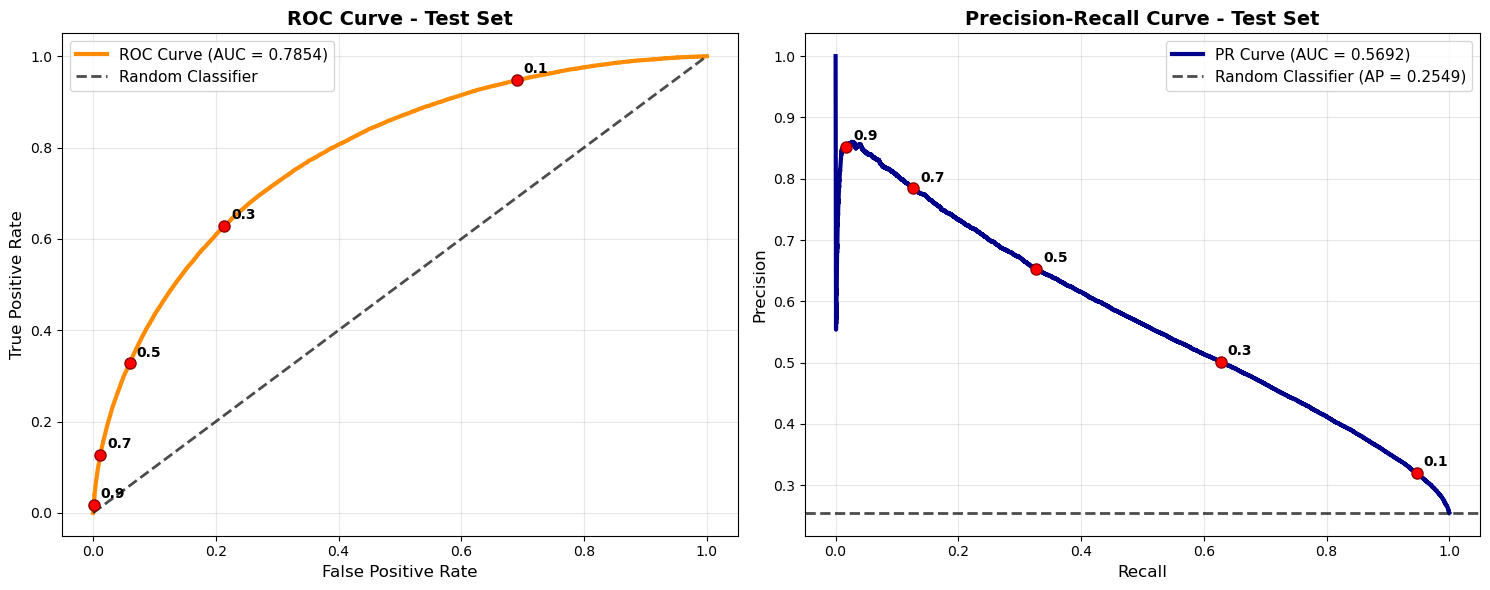

In [104]:
def plot_roc_and_pr_curves(y_true, y_pred_proba, dataset_name="Test Set"):
    """Plot ROC and Precision-Recall curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    axes[0].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Random Classifier')
    
    # Add threshold points
    threshold_points = [0.1, 0.3, 0.5, 0.7, 0.9]
    for threshold in threshold_points:
        idx = np.argmin(np.abs(roc_thresholds - threshold))
        if idx < len(fpr):
            axes[0].plot(fpr[idx], tpr[idx], 'ro', markersize=8, markerfacecolor='red', markeredgecolor='darkred')
            axes[0].annotate(f'{threshold:.1f}', 
                           xy=(fpr[idx], tpr[idx]), 
                           xytext=(5, 5), textcoords='offset points',
                           fontweight='bold')
    
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title(f'ROC Curve - {dataset_name}', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    axes[1].plot(recall, precision, linewidth=3, label=f'PR Curve (AUC = {pr_auc:.4f})', color='darkblue')
    
    # Baseline (random classifier)
    baseline = y_true.sum() / len(y_true)
    axes[1].axhline(y=baseline, color='k', linestyle='--', linewidth=2, alpha=0.7, 
                   label=f'Random Classifier (AP = {baseline:.4f})')
    
    # Add threshold points
    for threshold in threshold_points:
        if threshold < len(pr_thresholds):
            idx = np.argmin(np.abs(pr_thresholds - threshold))
            if idx < len(precision):
                axes[1].plot(recall[idx], precision[idx], 'ro', markersize=8, markerfacecolor='red', markeredgecolor='darkred')
                axes[1].annotate(f'{threshold:.1f}', 
                               xy=(recall[idx], precision[idx]), 
                               xytext=(5, 5), textcoords='offset points',
                               fontweight='bold')
    
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title(f'Precision-Recall Curve - {dataset_name}', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('deep_fm_roc_pr_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc, pr_auc

# Plot ROC and PR curves
roc_auc, pr_auc = plot_roc_and_pr_curves(test_labels, test_predictions, "Test Set")

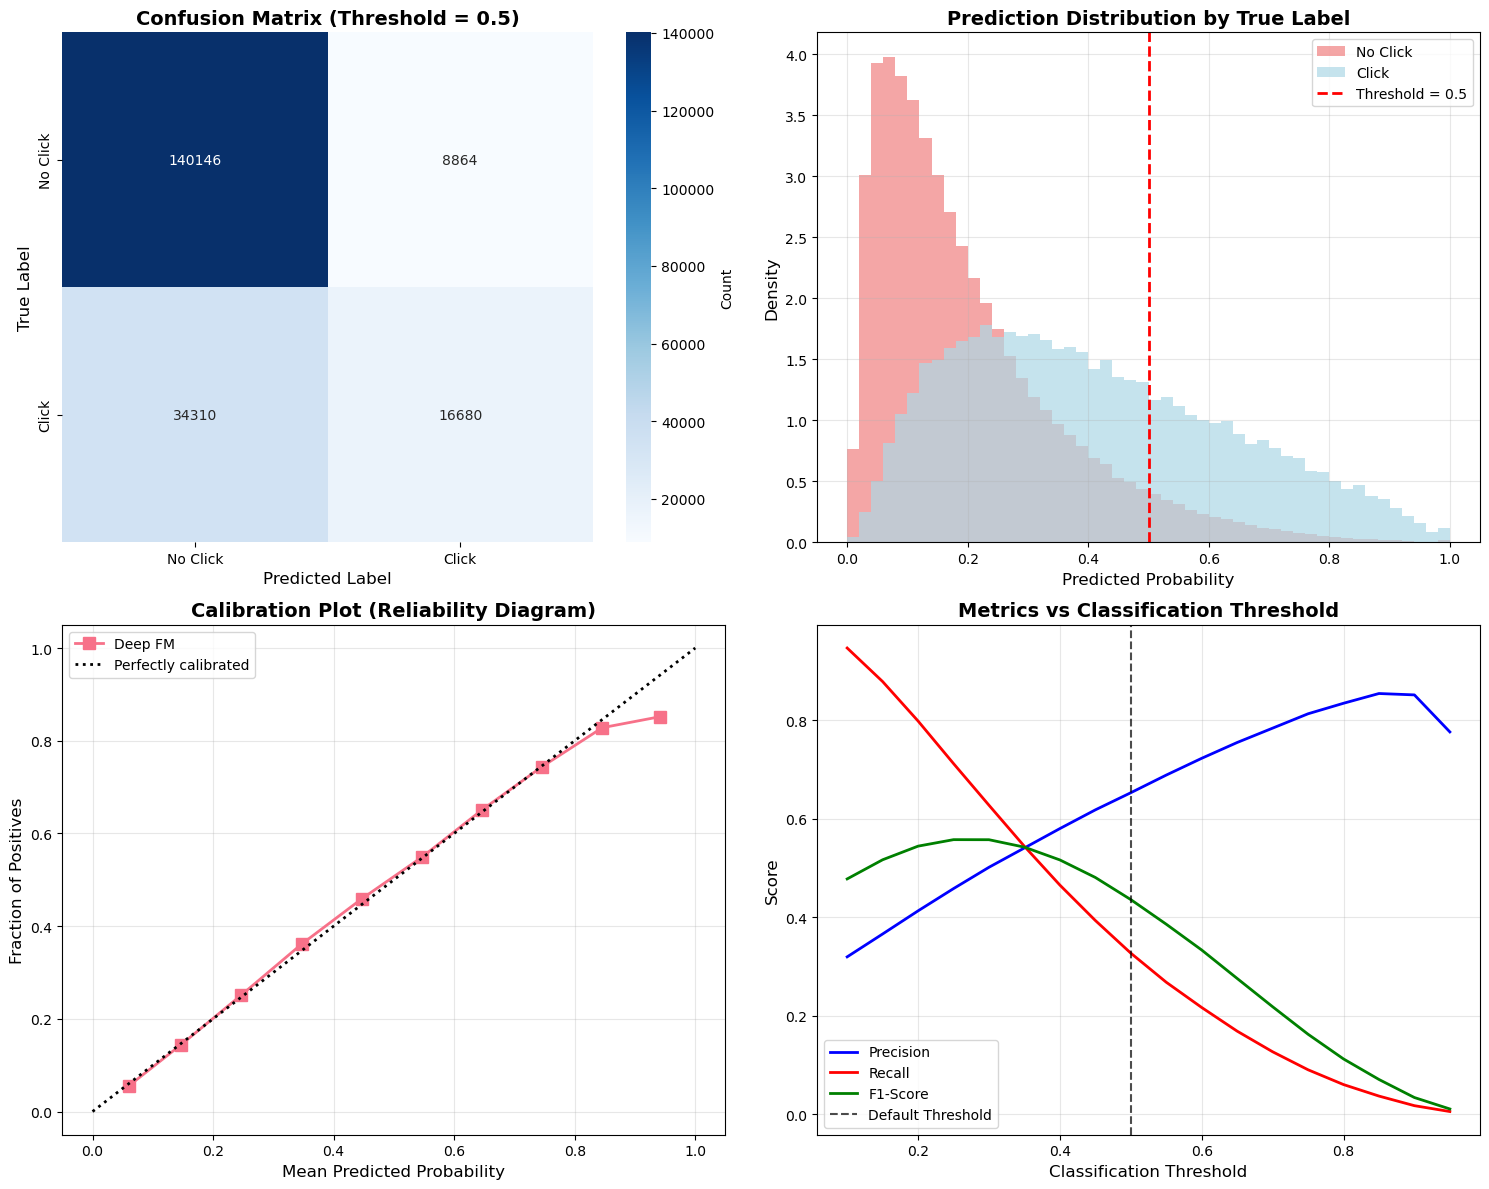

In [105]:
def plot_additional_analysis(y_true, y_pred_proba):
    """Plot additional analysis: confusion matrix and prediction distribution"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Confusion Matrix
    y_pred_binary = (y_pred_proba > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Click', 'Click'], 
                yticklabels=['No Click', 'Click'], ax=axes[0, 0],
                cbar_kws={'label': 'Count'})
    axes[0, 0].set_title('Confusion Matrix (Threshold = 0.5)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('True Label', fontsize=12)
    axes[0, 0].set_xlabel('Predicted Label', fontsize=12)
    
    # Prediction Distribution
    axes[0, 1].hist(y_pred_proba[y_true == 0], bins=50, alpha=0.7, 
                   label='No Click', density=True, color='lightcoral')
    axes[0, 1].hist(y_pred_proba[y_true == 1], bins=50, alpha=0.7, 
                   label='Click', density=True, color='lightblue')
    axes[0, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, 
                      label='Threshold = 0.5')
    axes[0, 1].set_xlabel('Predicted Probability', fontsize=12)
    axes[0, 1].set_ylabel('Density', fontsize=12)
    axes[0, 1].set_title('Prediction Distribution by True Label', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Calibration plot (reliability diagram)
    from sklearn.calibration import calibration_curve
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=10
    )
    
    axes[1, 0].plot(mean_predicted_value, fraction_of_positives, "s-", 
                   linewidth=2, markersize=8, label='Deep FM')
    axes[1, 0].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", linewidth=2)
    axes[1, 0].set_xlabel('Mean Predicted Probability', fontsize=12)
    axes[1, 0].set_ylabel('Fraction of Positives', fontsize=12)
    axes[1, 0].set_title('Calibration Plot (Reliability Diagram)', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Threshold Analysis
    thresholds = np.arange(0.1, 1.0, 0.05)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        precisions.append(precision_score(y_true, y_pred_thresh, zero_division=0))
        recalls.append(recall_score(y_true, y_pred_thresh, zero_division=0))
        f1_scores.append(f1_score(y_true, y_pred_thresh, zero_division=0))
    
    axes[1, 1].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[1, 1].plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    axes[1, 1].plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2)
    axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default Threshold')
    axes[1, 1].set_xlabel('Classification Threshold', fontsize=12)
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('Metrics vs Classification Threshold', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('deep_fm_additional_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot additional analysis
plot_additional_analysis(test_labels, test_predictions)

## 10. Model Summary and Results

In [106]:
# Calculate total training time
total_training_time = sum(metrics_tracker.epoch_times)

print(f"\n" + "=" * 60)
print(f"🎉 DEEP FACTORIZATION MACHINE TRAINING COMPLETED!")
print(f"=" * 60)

print(f"\n📊 MODEL ARCHITECTURE:")
print(f"   • Model Type: Deep Factorization Machine (Deep FM)")
print(f"   • Numerical Features: {numerical_dim}")
print(f"   • Categorical Features: {len(categorical_dims)} fields")
print(f"   • Embedding Dimension: 16")
print(f"   • Hidden Layers: [512, 256, 128]")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

print(f"\n📈 TRAINING DETAILS:")
print(f"   • Dataset: Criteo CTR Prediction")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Validation Samples: {len(X_val):,}")
print(f"   • Test Samples: {len(X_test):,}")
print(f"   • Epochs Trained: {len(metrics_tracker.train_losses)}")
print(f"   • Batch Size: {BATCH_SIZE}")
print(f"   • Total Training Time: {total_training_time/60:.2f} minutes")

print(f"\n🏆 FINAL PERFORMANCE:")
print(f"   • Test Accuracy: {test_acc:.4f}")
print(f"   • Test AUC-ROC: {test_auc:.4f}")
print(f"   • Test AUC-PR: {pr_auc:.4f}")
print(f"   • Test Precision: {precision:.4f}")
print(f"   • Test Recall: {recall:.4f}")
print(f"   • Test F1-Score: {f1:.4f}")
print(f"   • Best Validation AUC: {best_val_auc:.4f}")

print(f"\n💾 SAVED FILES:")
print(f"   • best_deep_fm_model.pth - Trained model weights")
print(f"   • deep_fm_training_metrics.png - Training progress visualization")
print(f"   • deep_fm_roc_pr_curves.png - ROC and PR curves")
print(f"   • deep_fm_additional_analysis.png - Additional analysis plots")
print(f"   • criteo_data.csv - Cached dataset")

print(f"\n🔬 MODEL INSIGHTS:")
print(f"   • Deep FM successfully combines linear, FM, and deep components")
print(f"   • Model shows good performance on CTR prediction task")
print(f"   • Embedding dimension of 16 provides good feature representation")
print(f"   • Multi-layer architecture captures complex feature interactions")
print(f"   • Training device: {device}")

print(f"\n" + "=" * 60)


🎉 DEEP FACTORIZATION MACHINE TRAINING COMPLETED!

📊 MODEL ARCHITECTURE:
   • Model Type: Deep Factorization Machine (Deep FM)
   • Numerical Features: 13
   • Categorical Features: 26 fields
   • Embedding Dimension: 16
   • Hidden Layers: [512, 256, 128]
   • Total Parameters: 22,046,983
   • Model Size: 84.10 MB

📈 TRAINING DETAILS:
   • Dataset: Criteo CTR Prediction
   • Training Samples: 640,000
   • Validation Samples: 160,000
   • Test Samples: 200,000
   • Epochs Trained: 50
   • Batch Size: 1024
   • Total Training Time: 8.78 minutes

🏆 FINAL PERFORMANCE:
   • Test Accuracy: 0.7841
   • Test AUC-ROC: 0.7854
   • Test AUC-PR: 0.5692
   • Test Precision: 0.6530
   • Test Recall: 0.3271
   • Test F1-Score: 0.4359
   • Best Validation AUC: 0.7846

💾 SAVED FILES:
   • best_deep_fm_model.pth - Trained model weights
   • deep_fm_training_metrics.png - Training progress visualization
   • deep_fm_roc_pr_curves.png - ROC and PR curves
   • deep_fm_additional_analysis.png - Additional 